In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import random

In [2]:
def get_data(dir,f_num):
    data = load_svmlight_file(dir,n_features=f_num) #读取数据，设定feature数量
    return data[0], data[1]


In [3]:
test_dir="./a9a.t"
train_dir="./a9a"

x_test,y_test=get_data(test_dir,123)
x_train,y_train=get_data(train_dir,123)



In [4]:
attr_num=x_train.shape[1] #属性的数量
m_test=x_test.shape[0] #test集合的样本数量
m_train=x_train.shape[0] #train集合的样本数量

x_train=x_train.todense() #化为稠密矩阵，后面方便操作
x_test=x_test.todense()  #同上

x_train=np.column_stack((np.ones(m_train),x_train)) #加一列1，作为偏置
x_test=np.column_stack((np.ones(m_test),x_test)) #加一列1，作为偏置

y_train=np.mat(y_train).T  #化为列向量
y_test=np.mat(y_test).T    #同上

print(m_test)
print(m_train)

16281
32561


In [5]:
def loss(w,x,y):   #hinge loss
    l=1-np.multiply(y,x*w)
    l2=(l>=0)
    r=np.multiply(l,l2)
    return np.mean(r)


def gradient(w,x,y,C=1):  #svm的梯度计算，包括正则项，C默认为1
    l=1-np.multiply(y,x*w)   #先做点乘
    l2=(l>=0)         #然后求出哪个元素大于等于0，化成布尔矩阵
    tmp=np.multiply(y,l2) #通过点乘进行筛选，大于等于0的项保留，小于0的项清除变为0
    return w-C*np.sum(np.multiply(x,tmp),0).T  #计算最终梯度


def accuracy(w,x,y,threshold):
    y_=x*w
    acc=np.mean(np.multiply(y_,y)>=threshold)
    return acc

In [6]:
#四种优化算法

#eta:learning rate, C: hinge-loss factor
#y:label,eta: learning rate, epoch:loop epoch,batch_size: batch size in one loop
def gradientDescent(w,x,y,eta,epoch,batch_size,C):
    loss_train=[]
    loss_test=[]
    for j in range(epoch):
        i=random.randint(0,m_train-batch_size)
        #g=eta*np.mean(mul/(1+np.exp(index)),0).T-eta*lamda*w
        #w=(1-eta*lamda)*w+eta*np.mean(mul/(1+np.exp(index)),0).T
        #w=w+g
        x_t=x[i:i+batch_size]
        y_t=y[i:i+batch_size]
        #print(x_t[0])
        g=gradient(w,x_t,y_t,C)
        w=w-eta*g
        loss_train.append(loss(w,x_t,y_t))
        loss_test.append(loss(w,x_test,y_test))
    return w,loss_train,loss_test
    
#eta:learning rate, C: hinge-loss factor
#y:label,eta: learning rate, epoch:loop epoch,m: batch size in one loop
# gamma: forget rate
    
def NAG(w,x,y,gamma,eta,epoch,C,m):
    delta_w=0
    test_loss=[]
    train_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-m)
        x_t=x[k:k+m]
        y_t=y[k:k+m]
        g=gradient(w-gamma*delta_w,x_t,y_t,C)
        delta_w=gamma*delta_w+eta*g
        w=w-delta_w
        test_loss.append(loss(w,x_test,y_test))
        train_loss.append(loss(w,x_t,y_t))
    return w,train_loss,test_loss


#eta:learning rate, C: hinge loss factor
#y:label,eta: learning rate, epoch:loop epoch,gamma: forgetting rate, m: batch size in one loop
def RMS(w,x,y,eta,epoch,gamma,C,m):
    epison=0.0001
    G=0
    test_loss=[]
    train_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-m)
        x_t=x[k:k+m]
        y_t=y[k:k+m]
        g=gradient(w,x_t,y_t,C)
        G=gamma*G+(1-gamma)*np.square(g)
        print(G)
        #print(E.shape)
        delta_w=eta*np.multiply(1/np.sqrt(G+epison),g)
        w=w-delta_w
        train_loss.append(loss(w,x_t,y_t))
        test_loss.append(loss(w,x_test,y_test))
        #print(loss(w,x_test,y_test))
    return w,train_loss,test_loss

# C: hinge loss factor
#y:label,eta: learning rate, epoch:loop epoch,gamma: forgetting rate, m: batch size in one loop
def AdaDelta(w,x,y,gamma,C,epoch,m): #without learning rate
    epison=0.0001
    G=0
    delta=0
    test_loss=[]
    train_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-m)
        x_t=x[k:k+m]
        y_t=y[k:k+m]
        g=gradient(w,x_t,y_t,C)
        G=gamma*G+(1-gamma)*np.square(g)
        delta_w=-np.multiply(np.sqrt(delta+epison)/np.sqrt(G+epison),g)
        w=w+delta_w
        delta=gamma*delta+(1-gamma)*np.square(delta_w)
        test_loss.append(loss(w,x_test,y_test))
        train_loss.append(loss(w,x_t,y_t))
    return w,train_loss,test_loss

# lamda:lambda before w if logistic regression is used, C if hinge-loss is used
#y:label,eta: learning rate, epoch:loop epoch,gamma: forgetting rate, beta: forgetting rate, m: batch size in one loop
#gradient: gradient function, loss:loss function

def Adam(w,x,y,eta,gamma,beta,epoch,batch_size,C):
    epison=0.0001
    G=0    #square mean
    m=0    #weighted mean
    delta=0
    test_loss=[]
    train_loss=[]
    for i in range(epoch):
        k=random.randint(0,m_train-batch_size)
        x_t=x[k:k+batch_size]
        y_t=y[k:k+batch_size]
        g=gradient(w,x_t,y_t,C)    
        m=beta*m+(1-beta)*g
        G=gamma*G+(1-gamma)*np.square(g)     
        alpha=eta*np.sqrt(1-gamma)/(1-beta)  
        w=w-alpha*m/np.sqrt(G+epison)
        #print(loss(w,x_test,y_test))
        test_loss.append(loss(w,x_test,y_test))
        train_loss.append(loss(w,x_t,y_t))
    return w,train_loss,test_loss

    

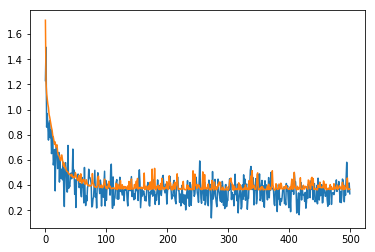

0.738345310485


In [20]:
#gradient_descent
eta=0.01
C=1
epoch=500
batch_size=64
#w=np.zeros([attr_num+1,1])
w=np.random.standard_normal([attr_num+1,1])

w,loss_train,loss_test=gradientDescent(w,x_train,y_train,eta,epoch,batch_size,C)
#print(x_test.shape)


iteration=list(range(epoch))
plt.figure()
plt.plot(iteration,loss_train)
plt.plot(iteration,loss_test)
plt.show()

print(accuracy(w,x_test,y_test,0.5))

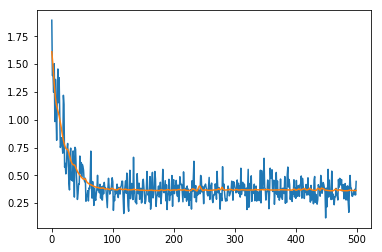

0.842638658559
0.839869782869


In [8]:
#NAG
eta=0.001
C=1
epoch=500
gamma=0.9
batch_size=64
#w=np.zeros([attr_num+1,1])
w=np.random.standard_normal([attr_num+1,1])
w,train_loss,test_loss=NAG(w,x_train,y_train,gamma,eta,epoch,C,batch_size)

#print(w)
iteration=list(range(epoch))
plt.figure()
plt.plot(iteration,train_loss)
plt.plot(iteration,test_loss)
plt.show()

print(accuracy(w,x_test,y_test,0))
print(accuracy(w,x_train,y_train,0))

[[  7.21933586e+01]
 [  7.61347995e+00]
 [  8.81718498e+00]
 [  3.13414738e+00]
 [  3.14459082e+00]
 [  3.80469558e+00]
 [  2.59291093e+01]
 [  2.10226960e+00]
 [  9.11696568e-02]
 [  1.29491443e-01]
 [  2.18102509e-01]
 [  4.58517680e-01]
 [  5.34599833e-03]
 [  2.05623409e-01]
 [  2.41132974e+00]
 [  9.04057539e+00]
 [  1.53831356e+00]
 [  4.58679525e-01]
 [  4.40904479e+00]
 [  2.51672606e-01]
 [  3.29104298e+01]
 [  5.21831268e-02]
 [  6.20766960e-01]
 [  4.24829071e-01]
 [  2.25486193e+00]
 [  6.76602529e-05]
 [  3.43176576e-03]
 [  2.64497017e-01]
 [  1.46867642e-03]
 [  8.86973249e-03]
 [  1.53436423e-03]
 [  7.28935055e-01]
 [  3.58965689e-03]
 [  1.92352211e-01]
 [  2.54726607e-01]
 [  5.56598558e+00]
 [  1.44679823e-01]
 [  3.56287926e+01]
 [  7.56676586e-01]
 [  2.75872927e-01]
 [  1.91892824e-01]
 [  5.66564166e+00]
 [  2.90825107e+01]
 [  4.75101494e-01]
 [  1.08321726e+00]
 [  9.29349326e-01]
 [  1.17234873e-01]
 [  2.43483322e-02]
 [  1.56849934e+00]
 [  2.24698593e+00]


[[  2.37414908e+02]
 [  9.59053161e+01]
 [  1.66526409e+01]
 [  7.30198415e+00]
 [  1.95701372e+01]
 [  6.68471970e+00]
 [  1.24050983e+02]
 [  3.92118402e+00]
 [  1.15330517e+00]
 [  9.29898965e-01]
 [  2.03277256e+00]
 [  6.30629773e+00]
 [  3.32960117e-03]
 [  1.51552449e+00]
 [  2.19801432e+01]
 [  1.83417088e+01]
 [  1.56692992e+01]
 [  8.36849391e+00]
 [  1.84118155e+01]
 [  3.72302208e+01]
 [  1.02564030e+02]
 [  1.38857687e+00]
 [  1.42098490e+01]
 [  6.11819733e+00]
 [  6.26503538e+00]
 [  1.39339071e+00]
 [  1.00457598e+00]
 [  5.15224852e-01]
 [  3.89582597e-01]
 [  1.05300093e+01]
 [  3.94177913e-01]
 [  5.68988864e+00]
 [  9.72604599e-01]
 [  3.40819992e+00]
 [  2.00080642e+00]
 [  4.70774440e+01]
 [  9.99189724e+00]
 [  1.16869135e+02]
 [  3.03346766e+00]
 [  1.08093962e+01]
 [  2.98687409e+01]
 [  1.40168657e+01]
 [  2.47576590e+02]
 [  1.44139289e+00]
 [  1.91645715e+00]
 [  7.21400789e+00]
 [  6.48386520e-01]
 [  1.59419877e+00]
 [  7.99534876e+00]
 [  3.01091772e+01]


 [  9.25140355e-04]]
[[  4.90271639e+01]
 [  4.73649399e+01]
 [  3.88913638e+00]
 [  5.13142582e+00]
 [  2.72686528e+01]
 [  3.33314073e+00]
 [  2.96404435e+01]
 [  2.64015861e+00]
 [  1.38975221e+00]
 [  1.57105908e+00]
 [  2.57650867e+00]
 [  2.62379843e+00]
 [  2.17332035e-04]
 [  1.02054906e+00]
 [  4.93868608e+00]
 [  7.51248268e+00]
 [  7.41599043e+00]
 [  4.03241616e+00]
 [  8.80404695e+00]
 [  1.60372590e+01]
 [  5.80432100e+01]
 [  6.48977398e-01]
 [  1.98913915e+01]
 [  7.69293029e+00]
 [  3.41649092e+00]
 [  7.28110292e-01]
 [  2.46058201e-01]
 [  3.69651928e-01]
 [  3.47524501e-01]
 [  1.35288726e+01]
 [  3.05889043e-01]
 [  2.01840147e+00]
 [  5.58029250e-01]
 [  2.27649327e+00]
 [  1.57347429e+00]
 [  1.52228898e+01]
 [  1.28436913e+01]
 [  6.86369521e+01]
 [  1.89613039e+00]
 [  1.77538936e+01]
 [  6.69729266e+01]
 [  6.49414293e+00]
 [  1.28407688e+02]
 [  4.93741554e-01]
 [  3.94748005e-01]
 [  4.28670569e+00]
 [  3.62800117e-01]
 [  2.17987709e+00]
 [  4.68040277e+00]

[[  3.73479449e+01]
 [  2.82972614e+01]
 [  5.02471411e+00]
 [  7.10025855e+00]
 [  1.61341620e+01]
 [  3.27984110e+00]
 [  1.77570890e+01]
 [  3.84071645e+00]
 [  1.52196986e+00]
 [  1.03572932e+00]
 [  2.03494176e+00]
 [  3.06399812e+00]
 [  1.12389874e-02]
 [  5.75072637e-01]
 [  4.15467258e+00]
 [  4.90592028e+00]
 [  5.86636075e+00]
 [  5.70152241e+00]
 [  7.92799701e+00]
 [  3.17569941e+01]
 [  2.56896312e+01]
 [  4.43073498e-01]
 [  1.33251253e+01]
 [  3.91011828e+00]
 [  1.56037203e+00]
 [  9.25582933e-01]
 [  3.69702912e-01]
 [  3.08336248e-01]
 [  1.25287857e-01]
 [  9.03070617e+00]
 [  2.65943860e-01]
 [  5.68824040e-01]
 [  4.92082264e-01]
 [  1.87872603e+00]
 [  9.12359483e-01]
 [  9.26303327e+00]
 [  7.73660452e+00]
 [  3.23186555e+01]
 [  2.02055407e+00]
 [  9.82568028e+00]
 [  2.70378733e+01]
 [  2.15095756e+00]
 [  8.27534621e+01]
 [  2.76075099e-01]
 [  5.49657980e-01]
 [  2.91499882e+00]
 [  1.74756921e-01]
 [  1.66013972e+00]
 [  4.44155242e+00]
 [  9.10834657e+00]


[[  3.38741832e+01]
 [  1.22632712e+01]
 [  3.79938732e+00]
 [  7.13946385e+00]
 [  1.78956520e+01]
 [  1.06248897e+01]
 [  3.34689603e+01]
 [  1.60437916e+00]
 [  1.32268309e+00]
 [  1.34923632e+00]
 [  1.61548423e+00]
 [  3.80949510e+00]
 [  9.01081310e-04]
 [  2.94891757e-01]
 [  6.08381417e+00]
 [  3.28697566e+00]
 [  8.89979839e+00]
 [  9.43818601e+00]
 [  6.59509673e+00]
 [  2.34306023e+01]
 [  1.49757338e+01]
 [  4.17082776e-01]
 [  1.32736854e+01]
 [  4.35099157e+00]
 [  1.78842300e+00]
 [  3.39918048e-01]
 [  2.87964885e-01]
 [  1.95427456e-01]
 [  1.95473412e-01]
 [  6.95111403e+00]
 [  2.01267821e-01]
 [  3.14647902e-01]
 [  7.05262989e-01]
 [  1.28967023e+00]
 [  7.34058180e-01]
 [  6.21149321e+00]
 [  7.32986004e+00]
 [  1.85170048e+01]
 [  1.39873022e+00]
 [  1.48881771e+01]
 [  3.07685027e+01]
 [  4.72078815e+00]
 [  4.59903871e+01]
 [  5.40435281e-01]
 [  1.65995387e-01]
 [  2.47692916e+00]
 [  5.46324130e-02]
 [  2.02898725e+00]
 [  4.09192040e+00]
 [  7.47155101e+00]


 [  4.69542237e-07]]
[[  1.90788483e+01]
 [  4.84966138e+00]
 [  5.09373756e+00]
 [  4.67840025e+00]
 [  1.13384898e+01]
 [  6.34056227e+00]
 [  1.48159523e+01]
 [  2.92797939e+00]
 [  2.22368197e+00]
 [  9.77820356e-01]
 [  3.07630528e+00]
 [  1.98458901e+00]
 [  5.82196399e-05]
 [  1.08472469e-01]
 [  4.42163122e+00]
 [  7.11960806e+00]
 [  4.27895430e+00]
 [  5.17164018e+00]
 [  3.40242482e+00]
 [  1.67360656e+01]
 [  1.41736394e+01]
 [  2.63874389e-01]
 [  8.59930338e+00]
 [  4.06848934e+00]
 [  7.75451189e-01]
 [  6.11125534e-01]
 [  9.06583479e-02]
 [  4.64158866e-01]
 [  2.91046817e-01]
 [  7.04897979e+00]
 [  1.41197432e-01]
 [  5.52497804e-01]
 [  3.43046456e-01]
 [  4.74290953e-01]
 [  4.43255607e-01]
 [  5.65059416e+00]
 [  4.55838399e+00]
 [  1.73720665e+01]
 [  1.24380834e+00]
 [  9.37471592e+00]
 [  1.58540232e+01]
 [  2.51470356e+00]
 [  1.69231803e+01]
 [  2.91367400e-01]
 [  4.19967401e-01]
 [  1.75827360e+00]
 [  4.97610173e-02]
 [  9.00524365e-01]
 [  4.30910415e+00]

[[  1.93203994e+01]
 [  3.32178575e+00]
 [  5.87449999e+00]
 [  5.72109680e+00]
 [  8.34143414e+00]
 [  5.26223197e+00]
 [  2.20148129e+01]
 [  1.60951337e+00]
 [  1.33470555e+00]
 [  1.34677263e+00]
 [  1.89640507e+00]
 [  1.31720398e+00]
 [  5.35336428e-02]
 [  2.76929517e-02]
 [  3.50411216e+00]
 [  5.41981038e+00]
 [  3.80554093e+00]
 [  3.87683362e+00]
 [  1.15432553e+01]
 [  1.41579764e+01]
 [  1.15025051e+01]
 [  3.07623724e-01]
 [  7.99479779e+00]
 [  1.99288934e+00]
 [  1.03448062e+00]
 [  9.32691130e-01]
 [  6.94794051e-02]
 [  6.34375768e-01]
 [  1.03069567e-01]
 [  4.26793044e+00]
 [  1.45511170e-01]
 [  4.22851511e-01]
 [  4.88485119e-01]
 [  6.92646932e-01]
 [  1.85107937e-01]
 [  3.30782981e+00]
 [  5.10638503e+00]
 [  1.28384221e+01]
 [  1.20390911e+00]
 [  8.76866333e+00]
 [  1.66040518e+01]
 [  1.21642190e+00]
 [  9.11812215e+00]
 [  8.63498623e-02]
 [  2.67660452e-01]
 [  1.50957100e+00]
 [  6.46963073e-02]
 [  5.24835689e-01]
 [  5.56235130e+00]
 [  2.96037629e+00]


[[  2.58758637e+01]
 [  1.52354394e+00]
 [  3.81984469e+00]
 [  4.36902341e+00]
 [  9.21759386e+00]
 [  3.76919422e+00]
 [  1.81488445e+01]
 [  1.36413361e+00]
 [  1.81127446e+00]
 [  9.41638916e-01]
 [  1.79582444e+00]
 [  9.39820646e-01]
 [  3.92965194e-03]
 [  2.76211074e-03]
 [  3.30089978e+00]
 [  4.08323409e+00]
 [  3.56854434e+00]
 [  6.45741811e+00]
 [  7.99377542e+00]
 [  1.54850279e+01]
 [  9.21368670e+00]
 [  3.85547625e-01]
 [  3.66333612e+00]
 [  2.06849158e+00]
 [  1.09572618e+00]
 [  7.16087772e-01]
 [  2.16125847e-01]
 [  2.91551968e-01]
 [  1.41455742e-01]
 [  3.65716056e+00]
 [  2.64485679e-01]
 [  2.17050248e-01]
 [  5.80374085e-01]
 [  4.25147659e-01]
 [  5.50087682e-02]
 [  3.43605609e+00]
 [  2.44830997e+00]
 [  1.11980921e+01]
 [  1.80060534e+00]
 [  1.12310164e+01]
 [  2.09621991e+01]
 [  1.07796156e+00]
 [  9.97408952e+00]
 [  1.50153791e-01]
 [  1.94559172e-01]
 [  4.95031764e-01]
 [  4.69938900e-03]
 [  3.43055440e-01]
 [  3.37584236e+00]
 [  2.52908472e+00]


[[  3.15885499e+01]
 [  1.19733740e+00]
 [  4.49915075e+00]
 [  8.01693246e+00]
 [  8.75106433e+00]
 [  5.90649023e+00]
 [  2.44367674e+01]
 [  1.67609360e+00]
 [  7.11462926e-01]
 [  9.62153001e-01]
 [  3.83495531e+00]
 [  2.32025374e+00]
 [  8.14647598e-02]
 [  1.98799554e-04]
 [  7.57816736e+00]
 [  9.60276667e+00]
 [  3.29481895e+00]
 [  4.48905593e+00]
 [  5.40778182e+00]
 [  1.67516531e+01]
 [  4.60913874e+00]
 [  2.03136373e-01]
 [  5.42198063e+00]
 [  6.76471491e-01]
 [  1.29237970e+00]
 [  1.41262433e+00]
 [  4.67916629e-02]
 [  4.23329510e-01]
 [  1.39800014e-01]
 [  5.90327489e+00]
 [  2.69545911e-01]
 [  2.08690546e-01]
 [  3.63220465e-01]
 [  1.16875100e-01]
 [  5.50015807e-03]
 [  2.40624833e+00]
 [  5.80404123e+00]
 [  4.94464501e+00]
 [  2.66585843e+00]
 [  2.29216523e+01]
 [  2.33256684e+01]
 [  1.87414171e+00]
 [  6.72433013e+00]
 [  1.97789168e-01]
 [  3.28685972e-01]
 [  4.76750594e-01]
 [  3.37517077e-04]
 [  4.39489273e-01]
 [  3.35146637e+00]
 [  1.62370394e+00]


 [  1.53971588e-11]]
[[  3.59882430e+01]
 [  1.01608840e+00]
 [  2.59282290e+00]
 [  8.21537671e+00]
 [  1.07620582e+01]
 [  6.85070588e+00]
 [  2.52420176e+01]
 [  3.06052780e+00]
 [  1.37362638e+00]
 [  1.53178485e+00]
 [  3.45240048e+00]
 [  1.83253658e+00]
 [  6.00262086e-03]
 [  1.42717800e-05]
 [  6.73594765e+00]
 [  4.13308084e+00]
 [  6.93776762e+00]
 [  3.29045881e+00]
 [  5.97586417e+00]
 [  1.30974065e+01]
 [  5.78942950e+00]
 [  1.99434612e-01]
 [  1.08435108e+01]
 [  1.59077111e+00]
 [  6.81157391e-01]
 [  6.90824145e-01]
 [  8.73111183e-02]
 [  1.89042121e-01]
 [  9.92579520e-02]
 [  3.15289935e+00]
 [  8.98874380e-02]
 [  2.25466685e-01]
 [  4.07096701e-01]
 [  2.30983318e-01]
 [  1.05504940e-02]
 [  1.01643513e+00]
 [  1.11772010e+01]
 [  5.79657759e+00]
 [  1.15906926e+00]
 [  9.38944540e+00]
 [  2.57542858e+01]
 [  2.25159905e+00]
 [  3.89120657e+00]
 [  1.11890283e-01]
 [  1.95143839e-01]
 [  3.16960956e-01]
 [  2.42302830e-05]
 [  7.61039100e-01]
 [  6.10412801e+00]

 [  1.10535893e-12]]
[[  2.34102739e+01]
 [  3.62405854e-01]
 [  4.38929508e+00]
 [  7.43377613e+00]
 [  1.09191574e+01]
 [  5.67639785e+00]
 [  1.95285106e+01]
 [  2.19483386e+00]
 [  1.31675575e+00]
 [  6.27178250e-01]
 [  2.28599736e+00]
 [  1.32028116e+00]
 [  2.62521877e-02]
 [  1.02456821e-06]
 [  2.87416932e+00]
 [  5.32321105e+00]
 [  4.60095693e+00]
 [  2.26492329e+00]
 [  4.59904437e+00]
 [  1.04395332e+01]
 [  5.47021326e+00]
 [  2.23750571e-01]
 [  4.75397992e+00]
 [  1.65199043e+00]
 [  1.23463087e+00]
 [  9.23213917e-01]
 [  6.56832403e-02]
 [  9.32464555e-02]
 [  3.94269690e-01]
 [  2.24672064e+00]
 [  1.61219076e-01]
 [  2.04342290e-01]
 [  4.04527368e-01]
 [  1.07392003e-01]
 [  1.96274667e-02]
 [  1.44838387e+00]
 [  6.52820440e+00]
 [  4.83076149e+00]
 [  2.68802433e+00]
 [  5.74794714e+00]
 [  1.82702684e+01]
 [  1.23928830e+00]
 [  3.54305877e+00]
 [  1.00068277e-01]
 [  2.76307603e-01]
 [  3.21816350e-01]
 [  4.34733767e-02]
 [  6.78041190e-01]
 [  3.80779054e+00]

 [  8.81705505e-14]]
[[  3.57309075e+01]
 [  1.26498528e+00]
 [  3.47462370e+00]
 [  8.86712862e+00]
 [  8.47257344e+00]
 [  6.05724456e+00]
 [  1.66905954e+01]
 [  1.55654846e+00]
 [  1.36136976e+00]
 [  8.89324439e-01]
 [  2.64877454e+00]
 [  1.21565555e+00]
 [  2.12324002e-03]
 [  8.17261621e-08]
 [  2.97786998e+00]
 [  4.64536706e+00]
 [  6.17646712e+00]
 [  3.89341753e+00]
 [  1.70025293e+00]
 [  8.38848487e+00]
 [  6.19473732e+00]
 [  2.15681391e-01]
 [  8.33389128e+00]
 [  1.16389749e+00]
 [  1.91373378e+00]
 [  1.44563595e+00]
 [  1.14322451e-01]
 [  3.17093231e-01]
 [  5.48212001e-02]
 [  2.20435547e+00]
 [  1.55144629e-01]
 [  1.59837023e-01]
 [  2.63301274e-01]
 [  2.65815719e-01]
 [  1.58303825e-03]
 [  1.29117686e+00]
 [  8.41341575e+00]
 [  6.68462230e+00]
 [  3.24634796e+00]
 [  9.30471540e+00]
 [  3.73225941e+01]
 [  2.82277604e+00]
 [  2.72789125e+00]
 [  2.98044442e-01]
 [  2.53398911e-01]
 [  1.94209182e-01]
 [  2.03973804e-02]
 [  1.42929444e+00]
 [  2.36024484e+00]

[[  1.71122165e+01]
 [  1.02501958e+00]
 [  3.91992861e+00]
 [  3.17210272e+00]
 [  4.44669553e+00]
 [  6.60465548e+00]
 [  9.91476447e+00]
 [  1.69561508e+00]
 [  1.34770611e+00]
 [  4.86167842e-01]
 [  1.94772903e+00]
 [  7.95105115e-01]
 [  1.26028670e-02]
 [  5.86710473e-09]
 [  3.66368183e+00]
 [  5.88872520e+00]
 [  3.75586335e+00]
 [  5.04938121e+00]
 [  2.52111714e+00]
 [  4.77812023e+00]
 [  5.93010486e+00]
 [  2.79827003e-02]
 [  3.81436096e+00]
 [  7.31166448e-01]
 [  1.17100830e+00]
 [  2.19132734e+00]
 [  2.40010428e-01]
 [  2.54620502e-01]
 [  1.79156715e-01]
 [  2.63912234e+00]
 [  6.09839843e-02]
 [  2.48845809e-01]
 [  6.07325308e-01]
 [  1.18180126e-01]
 [  9.21130182e-03]
 [  9.12848584e-01]
 [  3.65759336e+00]
 [  6.35490508e+00]
 [  2.25044881e+00]
 [  8.92319638e+00]
 [  1.89796871e+01]
 [  2.56471463e+00]
 [  1.60652871e+00]
 [  2.67183706e-01]
 [  5.78905544e-01]
 [  9.55025644e-02]
 [  1.49276496e-03]
 [  1.34386994e+00]
 [  4.12566425e+00]
 [  7.23922062e-01]


[[  5.03625026e+01]
 [  1.07362024e+00]
 [  2.65808709e+00]
 [  9.28805512e+00]
 [  1.06127115e+01]
 [  7.29583636e+00]
 [  2.53109681e+01]
 [  1.72806370e+00]
 [  1.66482494e+00]
 [  8.57738680e-01]
 [  2.97946483e+00]
 [  1.31170453e+00]
 [  1.09864288e-02]
 [  4.21198268e-10]
 [  3.89643291e+00]
 [  4.30338257e+00]
 [  8.65009589e+00]
 [  3.08553490e+00]
 [  4.82379869e+00]
 [  9.49852637e+00]
 [  9.08212209e+00]
 [  2.84403261e-01]
 [  8.15390438e+00]
 [  6.38443775e-01]
 [  6.38225050e-01]
 [  1.35669172e+00]
 [  9.70997383e-02]
 [  1.63711799e-01]
 [  1.26338909e-01]
 [  2.78620436e+00]
 [  5.43717660e-03]
 [  2.92313823e-01]
 [  6.98967982e-01]
 [  1.77683117e-01]
 [  8.84369877e-03]
 [  1.54340825e+00]
 [  8.80248137e+00]
 [  8.82196152e+00]
 [  2.22736232e+00]
 [  1.26351670e+01]
 [  2.99561493e+01]
 [  2.14745794e+00]
 [  2.70184334e+00]
 [  8.25926517e-02]
 [  4.27211413e-01]
 [  1.56046961e-01]
 [  1.39300532e-02]
 [  8.04109029e-01]
 [  4.66207242e+00]
 [  5.35185157e-01]


[[  5.01370186e+01]
 [  7.49541029e-01]
 [  1.95174079e+00]
 [  1.43203296e+01]
 [  9.72312021e+00]
 [  1.02055415e+01]
 [  1.77845608e+01]
 [  2.95080937e+00]
 [  1.71089870e+00]
 [  1.43690565e+00]
 [  3.84179241e+00]
 [  1.58100874e+00]
 [  6.07473635e-02]
 [  5.68976404e-11]
 [  5.91368551e+00]
 [  5.24475521e+00]
 [  9.70304991e+00]
 [  4.30019726e+00]
 [  2.68047675e+00]
 [  9.25124557e+00]
 [  1.07597660e+01]
 [  2.45865897e-01]
 [  4.22398408e+00]
 [  1.24147075e+00]
 [  4.31149773e-01]
 [  1.62251009e+00]
 [  9.99701733e-02]
 [  4.82229522e-01]
 [  2.43126470e-01]
 [  1.57499433e+00]
 [  2.45857909e-01]
 [  5.01525678e-01]
 [  3.81562403e-01]
 [  1.04999815e-01]
 [  1.20020286e-03]
 [  2.57774691e+00]
 [  4.02577127e+00]
 [  1.09161684e+01]
 [  2.20777203e+00]
 [  8.76071783e+00]
 [  5.04855196e+01]
 [  1.53761870e+00]
 [  3.01079222e+00]
 [  3.01666045e-01]
 [  2.25128427e-01]
 [  6.54307984e-02]
 [  5.03131836e-02]
 [  5.01255987e-01]
 [  4.77185130e+00]
 [  8.01401484e-01]


[[  5.16847584e+01]
 [  5.75982206e-01]
 [  6.62739213e+00]
 [  6.98712564e+00]
 [  8.98824792e+00]
 [  1.00399483e+01]
 [  2.85664095e+01]
 [  1.15549984e+00]
 [  1.10498005e+00]
 [  1.18900875e+00]
 [  2.58943134e+00]
 [  1.38319991e+00]
 [  8.39135563e-03]
 [  7.68602752e-12]
 [  7.82678676e+00]
 [  7.59590991e+00]
 [  7.13287531e+00]
 [  5.70462631e+00]
 [  7.99464537e+00]
 [  7.34056880e+00]
 [  5.63516072e+00]
 [  1.62325973e-01]
 [  8.66838703e+00]
 [  9.34049084e-01]
 [  5.64295861e-01]
 [  2.37550869e+00]
 [  1.24739473e-01]
 [  1.97866593e-01]
 [  3.07655859e-01]
 [  2.02403441e+00]
 [  3.57367203e-02]
 [  1.98179331e-01]
 [  3.66157704e-01]
 [  3.19738360e-02]
 [  1.62130478e-04]
 [  1.74465019e+00]
 [  9.50997894e+00]
 [  5.85507486e+00]
 [  2.72060886e+00]
 [  1.11723931e+01]
 [  3.59415340e+01]
 [  1.82884548e+00]
 [  3.80762608e+00]
 [  1.82357618e-01]
 [  1.47615514e-01]
 [  2.40113342e-01]
 [  6.90267025e-03]
 [  7.15552155e-01]
 [  4.23602738e+00]
 [  6.30447687e-01]


 [  5.95287988e-19]]
[[  4.22377118e+01]
 [  6.82965476e-01]
 [  3.96164526e+00]
 [  5.74603357e+00]
 [  1.25939364e+01]
 [  4.20755016e+00]
 [  1.90055203e+01]
 [  1.76150600e+00]
 [  2.26263529e+00]
 [  5.13981139e-01]
 [  8.37724006e-01]
 [  1.32754468e+00]
 [  6.04414727e-04]
 [  5.51778369e-13]
 [  3.30841457e+00]
 [  8.41642669e+00]
 [  6.17004946e+00]
 [  3.80769308e+00]
 [  8.38387103e+00]
 [  5.94594797e+00]
 [  5.43664488e+00]
 [  4.83990055e-01]
 [  6.46663499e+00]
 [  9.46059472e-01]
 [  6.14131590e-01]
 [  6.71903847e-01]
 [  3.68620647e-01]
 [  1.76746265e-01]
 [  1.23311807e-01]
 [  1.55673783e+00]
 [  2.76891528e-01]
 [  4.78570550e-01]
 [  5.30276525e-01]
 [  1.05837965e+00]
 [  1.70443394e-02]
 [  1.65622167e+00]
 [  6.61441197e+00]
 [  5.62293943e+00]
 [  1.09550693e+00]
 [  9.09170203e+00]
 [  2.49000936e+01]
 [  2.53704267e+00]
 [  2.01299070e+00]
 [  4.41769094e-01]
 [  1.20227882e-01]
 [  1.32553960e-01]
 [  1.94115005e-02]
 [  6.30260875e-01]
 [  2.99729084e+00]

 [  4.74840054e-20]]
[[  2.23525345e+01]
 [  1.22743851e+00]
 [  2.50960036e+00]
 [  5.57009306e+00]
 [  6.41587979e+00]
 [  1.05812904e+01]
 [  1.42185163e+01]
 [  2.03576421e+00]
 [  1.66078534e+00]
 [  1.08083900e+00]
 [  3.56706822e+00]
 [  1.17929636e+00]
 [  4.82120145e-05]
 [  4.40133979e-14]
 [  3.49679248e+00]
 [  5.71856571e+00]
 [  3.62596311e+00]
 [  7.74378885e+00]
 [  3.96667958e+00]
 [  7.61389268e+00]
 [  5.96165992e+00]
 [  2.67667151e-01]
 [  5.73830604e+00]
 [  6.27888822e-01]
 [  1.47629742e+00]
 [  6.63682471e-01]
 [  1.22415563e-01]
 [  1.41976939e-01]
 [  9.85421403e-03]
 [  3.65185696e+00]
 [  3.45119964e-02]
 [  2.05711822e-01]
 [  7.10734754e-01]
 [  1.94011215e-01]
 [  1.37172101e-03]
 [  1.04743151e+00]
 [  6.01236291e+00]
 [  6.33393318e+00]
 [  2.08494038e+00]
 [  1.25175284e+01]
 [  2.12144069e+01]
 [  1.62510411e+00]
 [  2.00920663e+00]
 [  2.16800850e-01]
 [  1.93350751e-01]
 [  1.76789835e-01]
 [  8.24622791e-02]
 [  9.04374456e-01]
 [  3.75555544e+00]

[[  5.01342609e+01]
 [  8.71184184e-01]
 [  3.24930088e+00]
 [  1.20706296e+01]
 [  7.55930354e+00]
 [  1.18338510e+01]
 [  2.60841014e+01]
 [  2.37038757e+00]
 [  2.16963422e+00]
 [  9.10380173e-01]
 [  2.57301972e+00]
 [  1.28892359e+00]
 [  1.53499346e-02]
 [  3.90088022e-15]
 [  6.94343284e+00]
 [  5.02658291e+00]
 [  1.16723408e+01]
 [  6.57900966e+00]
 [  6.77179538e+00]
 [  6.34918582e+00]
 [  8.03714645e+00]
 [  2.29803647e-01]
 [  1.19738275e+01]
 [  1.62857197e+00]
 [  7.78009120e-01]
 [  1.11720873e+00]
 [  1.35828471e-02]
 [  2.75939724e-01]
 [  3.46104286e-02]
 [  2.83154955e+00]
 [  2.39598901e-01]
 [  5.80491544e-01]
 [  6.01500102e-01]
 [  4.93589817e-02]
 [  1.21575807e-04]
 [  1.37801340e+00]
 [  1.24612073e+01]
 [  8.49908022e+00]
 [  1.87707200e+00]
 [  1.30430543e+01]
 [  3.98542853e+01]
 [  1.79662256e+00]
 [  1.91071782e+00]
 [  2.99372034e-01]
 [  3.85307536e-01]
 [  1.12454143e-01]
 [  7.73846466e-03]
 [  2.88855321e-01]
 [  5.72115792e+00]
 [  5.85841761e-01]


[[  3.22665498e+01]
 [  1.21141081e+00]
 [  2.13631267e+00]
 [  6.81486924e+00]
 [  8.42174544e+00]
 [  9.25326989e+00]
 [  2.16684366e+01]
 [  1.89596426e+00]
 [  1.58374596e+00]
 [  7.07275968e-01]
 [  1.64367182e+00]
 [  1.16547493e+00]
 [  1.11065928e-03]
 [  2.80043406e-16]
 [  5.04899312e+00]
 [  7.63331597e+00]
 [  4.43293297e+00]
 [  5.57486200e+00]
 [  3.29921029e+00]
 [  7.68144566e+00]
 [  6.69362528e+00]
 [  1.62080427e-01]
 [  6.28013141e+00]
 [  6.87313494e-01]
 [  5.94986201e-01]
 [  1.22325203e+00]
 [  1.35951660e-01]
 [  1.84903160e-01]
 [  3.33166478e-02]
 [  2.29169170e+00]
 [  1.07392767e-01]
 [  2.34554414e-01]
 [  4.33029990e-01]
 [  1.03966161e-01]
 [  8.72790271e-06]
 [  1.08154656e+00]
 [  5.98681570e+00]
 [  6.50180839e+00]
 [  1.40502309e+00]
 [  1.15346492e+01]
 [  2.44937553e+01]
 [  1.76685760e+00]
 [  2.10006227e+00]
 [  2.75184754e-01]
 [  3.98941812e-01]
 [  9.91819994e-02]
 [  5.58844175e-04]
 [  4.99633176e-01]
 [  2.88996437e+00]
 [  7.08024061e-01]


[[  3.75175748e+01]
 [  2.91640800e-01]
 [  3.52079345e+00]
 [  1.38931287e+01]
 [  6.95293549e+00]
 [  1.13445589e+01]
 [  2.25279493e+01]
 [  1.55640112e+00]
 [  7.33879632e-01]
 [  1.10820730e+00]
 [  3.37677841e+00]
 [  2.20628153e+00]
 [  9.01795460e-02]
 [  2.01042598e-17]
 [  3.39597384e+00]
 [  3.13442734e+00]
 [  1.20891075e+01]
 [  3.31250811e+00]
 [  5.31990558e+00]
 [  8.98760743e+00]
 [  9.73680775e+00]
 [  2.26465471e-01]
 [  6.00320027e+00]
 [  7.59032359e-01]
 [  9.71128326e-01]
 [  1.26520211e+00]
 [  5.95703396e-02]
 [  5.81776102e-01]
 [  5.64488406e-02]
 [  2.05634065e+00]
 [  3.94243834e-02]
 [  3.08844198e-01]
 [  9.43715920e-01]
 [  1.10784385e-01]
 [  9.57795564e-02]
 [  1.32402969e+00]
 [  6.07590765e+00]
 [  9.41940261e+00]
 [  2.25820791e+00]
 [  1.44482715e+01]
 [  2.53126619e+01]
 [  1.49705817e+00]
 [  1.45248659e+00]
 [  2.08120171e-01]
 [  3.21004667e-01]
 [  6.16161165e-02]
 [  4.01193122e-05]
 [  7.58322500e-01]
 [  2.81307033e+00]
 [  1.76187538e+00]


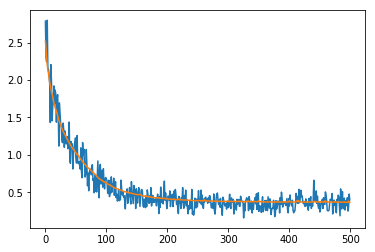

0.8407960199


In [7]:
#rms算法

eta=0.01
C=1
epoch=500
gamma=0.9
batch_size=64

#w=np.zeros([attr_num+1,1])
w=np.random.standard_normal([attr_num+1,1])
w,train_loss,test_loss=RMS(w,x_train,y_train,eta,epoch,gamma,C,batch_size)

iteration=list(range(epoch))
plt.figure()
plt.plot(iteration,train_loss)
plt.plot(iteration,test_loss)
plt.show()

print(accuracy(w,x_test,y_test,0))

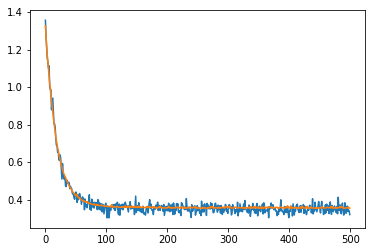

0.76389656655
0.765087067351


In [43]:
#adaDelta
epoch=500
gamma=0.7
batch_size=1024
C=1
#w=np.zeros([attr_num+1,1])
w=np.random.standard_normal([attr_num+1,1])
w,train_loss,test_loss=AdaDelta(w,x_train,y_train,gamma,C,epoch,batch_size)

iteration=list(range(epoch))
plt.figure()
plt.plot(iteration,train_loss)
plt.plot(iteration,test_loss)
plt.show()

print(accuracy(w,x_test,y_test,0.5))
print(accuracy(w,x_train,y_train,0.5))

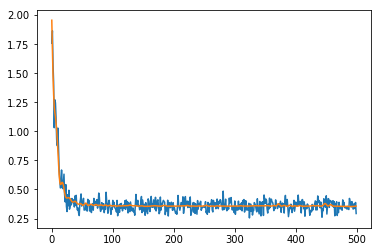

0.753516368773


In [54]:
#adam
epoch=500
gamma=0.999
eta=0.04
batch_size=256
beta=0.9
C=1
#w=np.zeros([attr_num+1,1])
w=np.random.standard_normal([attr_num+1,1])
w,train_loss,test_loss=Adam(w,x_train,y_train,eta,gamma,beta,epoch,batch_size,C)

iteration=list(range(epoch))
plt.figure()
plt.plot(iteration,train_loss)
plt.plot(iteration,test_loss)
plt.show()

print(accuracy(w,x_test,y_test,0.5))
#print(accuracy(w,x_train,y_train,0.5))